In [3]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis/thesis_code')
import packages.mine_generic as mine_g

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error, mean_squared_error


# 1. Benchmark models:

## Load and clean data:

Data length: 331 rows from 1996-01-31 00:00:00 to 2023-07-31 00:00:00
0           hicp_all
date                
1996-01-31      75.1
1996-02-29      75.6
1996-03-31      75.7
1996-04-30      75.6
1996-05-31      75.7


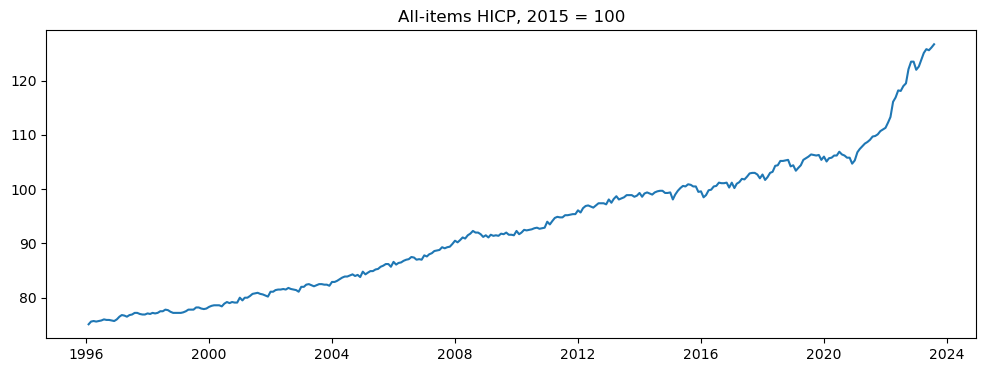

In [4]:
headline = mine_g.load_excel('data/hicp_all.xlsx', 'hicp_all')
mine_g.data_viz(headline, title= 'All-items HICP, 2015 = 100')

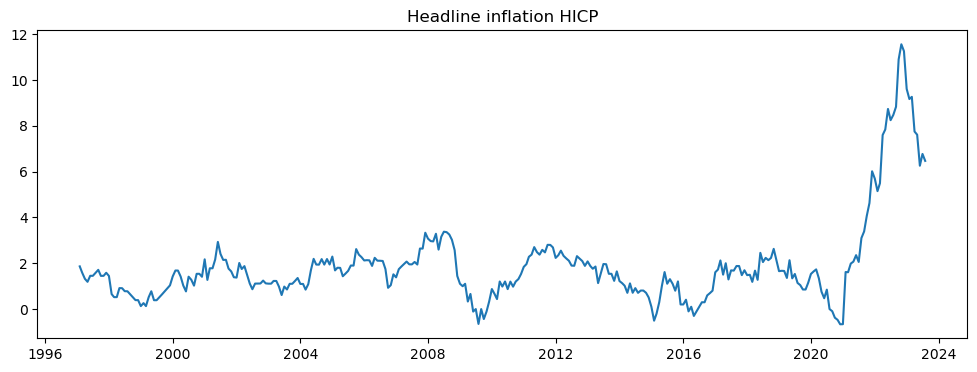

In [5]:
head_inf = mine_g.transform_yoy_rate(headline)
mine_g.data_viz(head_inf, title= 'Headline inflation HICP')
head_inf.to_csv('data/preprocessed/head_inflation.csv')

## Time series analysis:
- Test for autocorrelation
- ADF test for stationarity
- ACF and PACF plots
- Seasonal decomposition and plot residuals.
- ACF and PACF plot for differencing 1.

In [6]:

autocorr_values = head_inf.autocorr()
print("Autocorrelation:", autocorr_values) #large autocorr -> can be AR model

Autocorrelation: 0.9721133972549411


In [7]:
mine_g.dftest(head_inf)

Test Statistic        -3.198781
p-value                0.020055
Lags Used             14.000000
Observations Used    304.000000
dtype: float64
Time series is stationary!


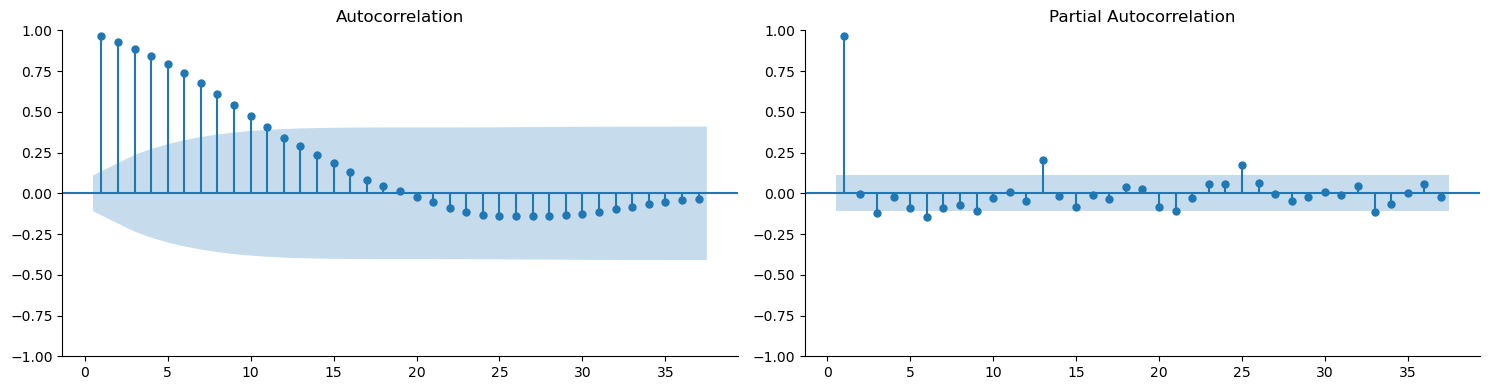

In [8]:
mine_g.plots_acf_pacf(head_inf, lags = 37)

ACF is initially large, then decays gradually to zero, then switch to be negative.
p = 1, 13, 25, 37,... have large PACF -> annual seasonality.

Also I'll split the data so to have out-of-sample forecast, and there's covid time, so I will split like:
training data: 1/1998-12/2015
test 1: 1/2016 - 12/2019 - precovid
test 2: 2020-2021 - during covid
test 3: 2022 - after covid and ukrain war and energy spike

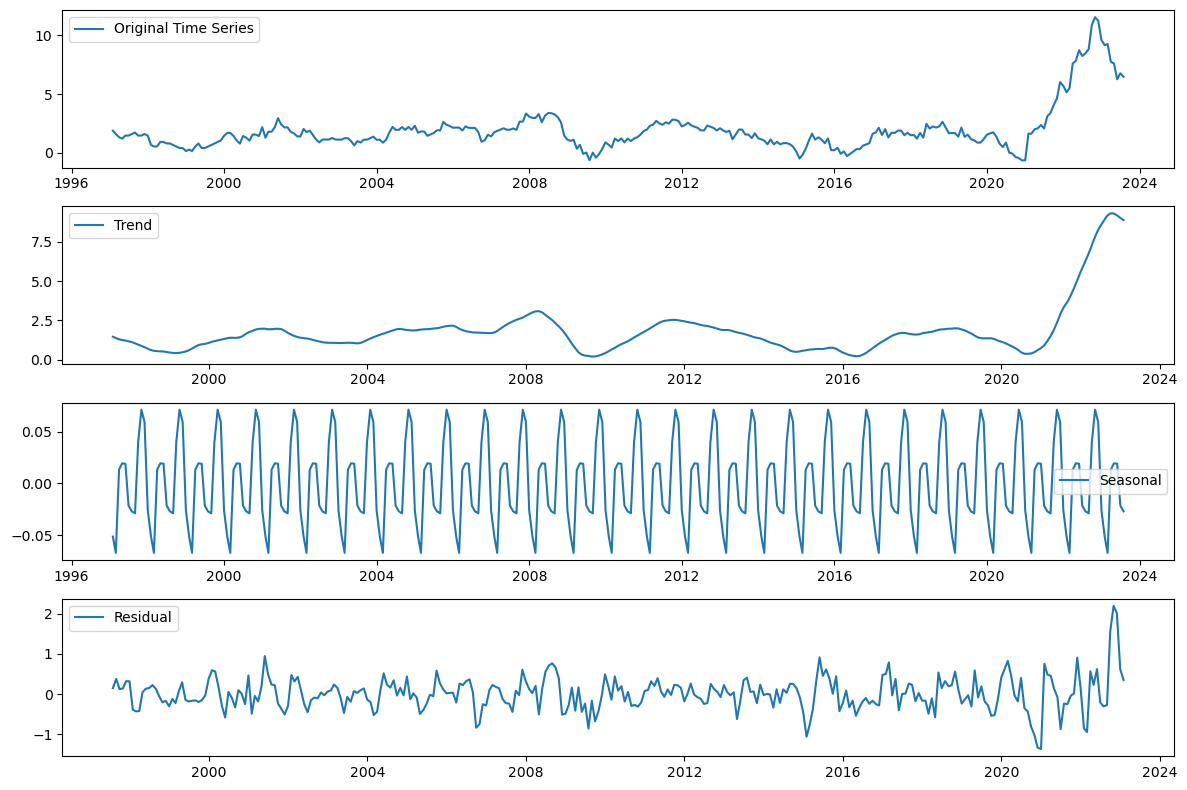

In [9]:
# Apply seasonal decomposition
result = seasonal_decompose(head_inf, model='additive')


# Plot the original time series
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(head_inf, label='Original Time Series')
plt.legend()

# Plot the trend component
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend()

# Plot the seasonal component
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

# Plot the residual component
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


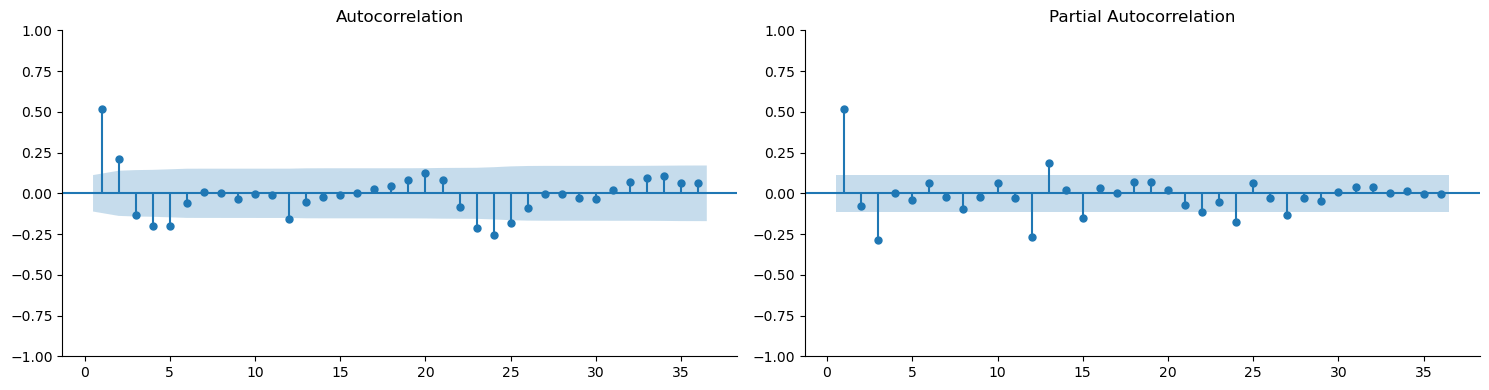

In [10]:
mine_g.plots_acf_pacf(result.resid[result.resid.notna()], lags=36);

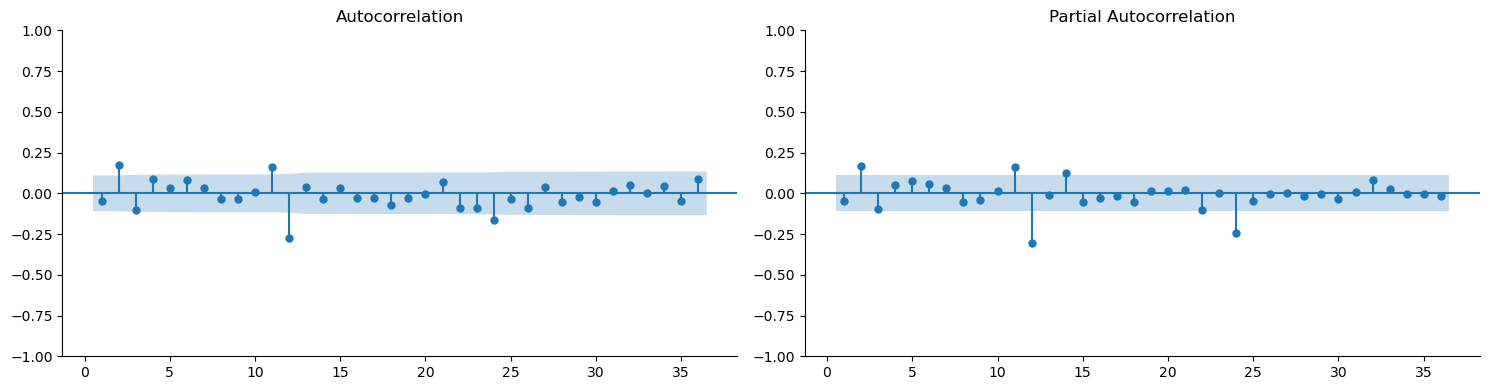

In [11]:
head_inf_year_diff = head_inf.diff(1)
mine_g.plots_acf_pacf(head_inf_year_diff.dropna(), lags=36)

In [12]:
head_inf_train = head_inf[head_inf.index <= '2015-12-31']
head_inf_test = head_inf[(head_inf.index > '2015-12-31') & (head_inf.index < '2023-01-01')]

## Model:

Try with the most basic model ARMA(1, 0, 0) then try with more complicated model.????

### AR(1) OLS:

In [13]:
import statsmodels.api as sm

y_train = head_inf_train[1:].values
X_train = head_inf_train[:-1].values


X_train = sm.add_constant(X_train)

model = sm.OLS(y_train,X_train)
results = model.fit()
y_pred_train = results.predict(X_train)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     1062.
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           3.69e-87
Time:                        20:53:25   Log-Likelihood:                -70.549
No. Observations:                 227   AIC:                             145.1
Df Residuals:                     225   BIC:                             151.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1213      0.047      2.582      0.010       0.029       0.214
x1             0.9132      0.028     32.585      0.000       0.858       0.968
==============================================================================
Omnibus:                        5.071   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                5.533
Skew:                          -0.209   Prob(JB):                       0.0629
Kurtosis:                       3.640   Cond. No.                         4.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Sanity check:
I build my own OLS calculation version:

We can see both methods have same results.

In [14]:
y_train = head_inf_train[1:]
X_train = head_inf_train[:-1]

X_with_intercept = np.column_stack((np.ones(len(X_train)), X_train))

beta_hat = np.linalg.inv(X_with_intercept.T.dot(X_with_intercept)).dot(X_with_intercept.T).dot(y_train)
beta_hat

array([0.12133756, 0.91316746])

-----

Do recursive forecast: y_pred_h1 is used as input to forecast y_pred_h2 since ols can forecast 1 horizon at a time.

In [15]:

X_test_h_1 = head_inf[(head_inf.index >= '2015-10-31') & (head_inf.index < '2023-01-01')]
X_test_h_1 = sm.add_constant(X_test_h_1)

y_pred_test_h_1 = results.predict(X_test_h_1)

X_test_h_2 = sm.add_constant(y_pred_test_h_1)
y_pred_test_h_2 = results.predict(X_test_h_2)

X_test_h_3 = sm.add_constant(y_pred_test_h_2)
y_pred_test_h_3 = results.predict(X_test_h_3)

y_pred = pd.DataFrame(columns=[f'ar_ols_h_{i}' for i in [1, 2, 3]])
y_pred['ar_ols_h_1'] = y_pred_test_h_1
y_pred['ar_ols_h_2'] = y_pred_test_h_2
y_pred['ar_ols_h_3'] = y_pred_test_h_3


I think I might chop wrongly.

In [18]:
y_pred

,ar_ols_h_1,ar_ols_h_2,ar_ols_h_3
date,,,
2015-10-31,1.224863,1.239843,1.253522
2015-11-30,0.305258,0.400090,0.486686
2015-12-31,0.305073,0.399921,0.486532
2016-01-31,0.493679,0.572149,0.643806
2016-02-29,0.029098,0.147909,0.256404
...,...,...,...
2022-08-31,8.188482,7.598793,7.060308
2022-09-30,10.074116,9.320693,8.632691
2022-10-31,10.680094,9.874052,9.138001


In [14]:
y_pred_chopped = RecursiveForecast.chop_forecast_to_fit(forecast_df=y_pred, y_test=head_inf_test)


In [16]:
save_forecast(y_pred_chopped, cat_file_path= 'data/forecast_results/head_infl_forecast.csv')

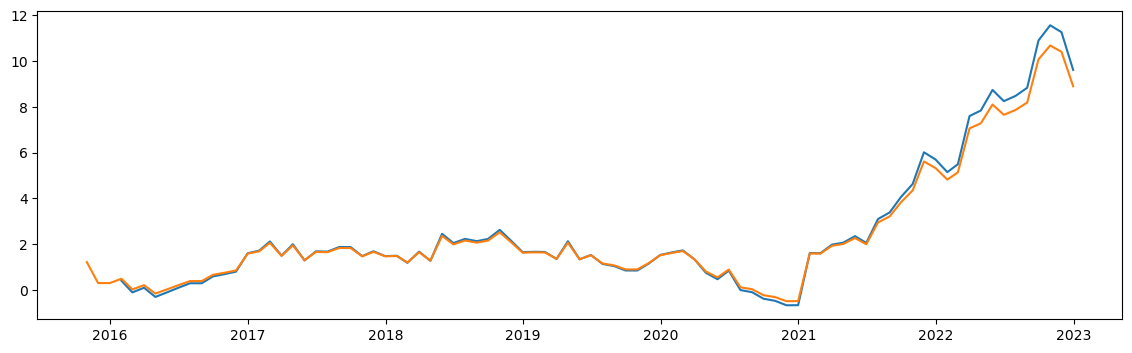

In [17]:
plt.figure(figsize=(14, 4))
plt.plot(head_inf_test)
plt.plot(y_pred_test_h_1)
plt.show()

### Model 2:
Model AR(1, 1, 0): 

In [ ]:
order1 = (1, 1, 0)
seasonal_order1 = (0, 0, 0, 0)

base_1 = ARIMA(head_inf_train, 
                order=order1,
                seasonal_order=seasonal_order1,
                trend ='n').fit()
base_1.summary()

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(base_1.resid, label = 'Residuals of model')
plt.axhline(base_1.resid.mean(), color = 'r')
plt.legend()
plt.show()

In [ ]:
base_1.plot_diagnostics(figsize= (18, 6))
plt.tight_layout()
plt.show()

In [ ]:
horizons = [1, 2, 3] # horizon

# function for forecasting:

def forecast_results(order, seasonal_order, horizons = horizons, N = len(head_inf_train), T = len(head_inf_test)):
    """
    Create forecast results after doing SARIMAX recursive forecast, using for baseline models
    Args:
    - order: trained order 
    - seasonal_order: seasonal order
    - horizon: forecast horizon
    - N: length of training period
    - T: length of test period
    """
    forecast_df = pd.DataFrame()
    
# Iterate through the time series data
    for h in horizons:
        forecasts = []    
        for i in range(1, T +1):
        
            # Define the expanding window training set
            train_data = head_inf[:N+i-h]
            print(f'Horizon {h}, step {i}')

            # Create and fit the SARIMAX model
            model = ARIMA(train_data, order=order, seasonal_order=seasonal_order, trend='n')
            model_fit = model.fit()
        
            # Forecast h step ahead
            pred = model_fit.forecast(steps =h)
            print('Prediction: ', pred)
            forecasts.append(pred.iloc[-1])
        # Assign the forecasted values to a new column in the DataFrame
        forecast_df[f'ar_110_h_{h}'] = forecasts
        
    forecast_df.set_index(head_inf_test.index, inplace = True)
    #forecast_df['Real_obs'] = head_inf_test.values

    return forecast_df

In [ ]:
forecast_df1 = forecast_results(order=order1, seasonal_order= seasonal_order1)
save_forecast(forecast_df1.reset_index(drop=True), cat_file_path= 'data/forecast_results/head_infl_forecast.csv')

In [ ]:
forecast_df1

------

In [ ]:
# Metric df:

metrics_df = pd.DataFrame(columns=['base1_rmse', 'base1_mae'], index=horizons)

for h in horizons:
    metrics_df.loc[h, 'base1_rmse'] = np.sqrt(mean_squared_error(forecast_df1['Real_obs'], forecast_df1[f'Horizon_{h}']))
    metrics_df.loc[h, 'base1_mae'] = mean_absolute_error(forecast_df1['Real_obs'], forecast_df1[f'Horizon_{h}'])

print(metrics_df)


In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(211)
plt.plot(forecast_df1.index, forecast_df1['Horizon_1'], label = 'Forecasts horizon 1')
plt.plot(forecast_df1['Real_obs'], label = 'Real headline CPI')
plt.legend()

plt.subplot(212)
plt.plot(forecast_df1['Error_horizon_1'], label = 'Error 1-step ahead')
plt.plot(forecast_df1['Error_horizon_2'], label = 'Error 2-step ahead')
plt.plot(forecast_df1['Error_horizon_3'], label = 'Error 3-step ahead')

plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.legend()
plt.show()


### Model 2:
Optimise the training data set

In [ ]:
stepwise_model = pm.auto_arima(head_inf_train, 
                            start_p=2, start_q=0,
                           max_p=12, max_q=12, m=12,
                           start_P=1, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                            information_criterion='bic') 
print(stepwise_model.bic())
print(stepwise_model.summary())

- The estimated standard deviation of the residuals (errors) is 0.1397. -> not 0
- Ljung-Box (Q): A test for autocorrelation of residuals. A value of 2.75 is observed, and a low p-value (0.10) suggests that there might be significant autocorrelation.
- Jarque-Bera (JB): A test for normality of residuals. The JB statistic is 1.27, and the p-value is 0.53, indicating that normality is not significantly violated.
- Heteroskedasticity (H): A test for constant variance of residuals. The H statistic is 1.23, and the p-value is 0.38, suggesting that there is no significant heteroskedasticity.

Skewness and Kurtosis:
- Skewness is approximately -0.02, indicating a slight left skewness.
- Kurtosis is 3.37, suggesting a distribution with moderate peakedness.


In [ ]:
stepwise_model.plot_diagnostics(figsize= (15, 6))
plt.tight_layout()
plt.show()

In [ ]:
order2 = stepwise_model.order
seasonal_order2 = stepwise_model.seasonal_order
print('order: ',order2)
print('seasonal order: ',seasonal_order2)

In [ ]:

sar = SARIMAX(head_inf_train, 
                order=order2,
                seasonal_order=seasonal_order2,
                trend ='n').fit()
sar.summary()

In [ ]:
#plot the residuals

plots_acf_pacf(sar.resid[sar.loglikelihood_burn:], lags=36);

Residuals are not white noise and still autocorrelated.

Now let's do out-of-sample forecast and calculate RMSE. 

## Forecast:
### Recursive Approach:
We apply the optimised model but adding more data recursively.

In [ ]:

forecast_df2 = forecast_results(order=order2, seasonal_order= seasonal_order2)
forecast_df2

In [ ]:
plt.figure(figsize = (12, 8))
plt.subplot(211)
plt.plot(forecast_df2.index, forecast_df2['Horizon_1'], label = 'Forecasts horizon 1')
plt.plot(forecast_df2['Real_obs'], label = 'Real headline CPI')
plt.legend()

plt.subplot(212)
plt.plot(forecast_df2['Error_horizon_1'], label = 'Error 1-step ahead')
plt.plot(forecast_df2['Error_horizon_2'], label = 'Error 2-step ahead')
plt.plot(forecast_df2['Error_horizon_3'], label = 'Error 3-step ahead')

plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.legend()
plt.show()
